In [1]:
from pathlib import Path

import numpy as np
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as F
from matplotlib import pyplot as plt
from torchvision.io import read_image  # type: ignore[import-untyped]
from torchvision.utils import draw_segmentation_masks


In [2]:
def show(imgs: list[torch.Tensor]):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

torch.Size([3, 512, 512])


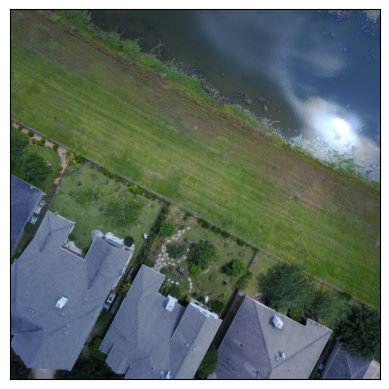

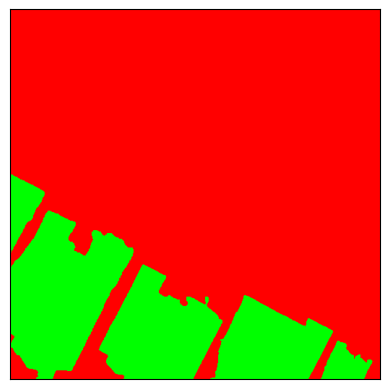

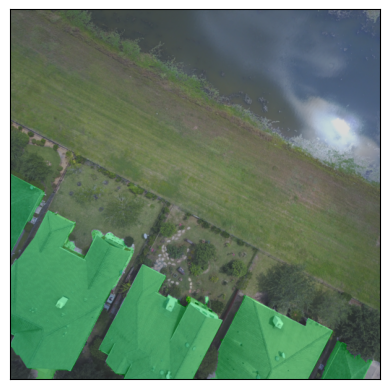

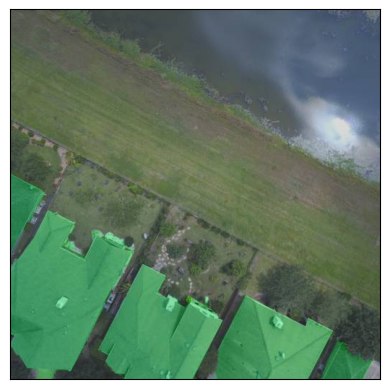

In [3]:
IMG_NUM = 7720

IMG_PATH = Path(f"data/floodnet_processed_512/FloodNet-Supervised_v1.0/train/train-org-img/{IMG_NUM}.png")
MASK_PATH = Path(f"data/floodnet_processed_512/FloodNet-Supervised_v1.0/train/train-label-img/{IMG_NUM}_lab.npz")
PREVIEW_PATH = Path(f"data/floodnet_processed_512/jpegs/FloodNet-Supervised_v1.0/train/train-org-img/{IMG_NUM}.jpeg")
img = read_image(str(IMG_PATH)).to(torch.float) / 255
mask_arr = np.load(MASK_PATH)["arr_0"]
mask = torch.tensor(mask_arr, dtype=torch.float).moveaxis(-1, 0)
print(mask.shape)
show(img)
show(mask)

colors = [
    (128, 128, 128),
    (0, 255, 0),
    (255, 0, 0),
]
show(draw_segmentation_masks((img * 255).to(torch.uint8), mask.to(torch.bool), alpha=0.3, colors=colors))

preview = read_image(str(PREVIEW_PATH)).to(torch.float) / 255
show(preview)


In [4]:
from inz.data.data_module_floodnet import FloodNetDataset, FloodNetModule

PROCESSED_DATA_PATH = Path("data/floodnet_processed_512/FloodNet-Supervised_v1.0")

dm = FloodNetModule(
    path=PROCESSED_DATA_PATH,
    train_batch_size=8,
    val_batch_size=8,
    test_batch_size=8,
    transform=T.Compose(
        transforms=[
            T.RandomHorizontalFlip(p=0.5),
            T.RandomApply(
                p=0.6, transforms=[T.RandomAffine(degrees=(-10, 10), scale=(0.9, 1.1), translate=(0.1, 0.1))]
            ),
        ]
    ),
)
dm.prepare_data()
dm.setup('fit')

In [5]:
it = iter(dm.train_dataloader())

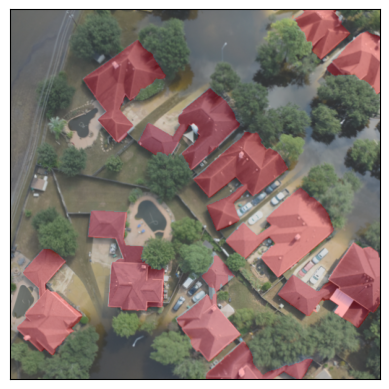

In [16]:
img, mask = next(it)
show(draw_segmentation_masks(((img[0, ...] + 1) * 127.5).to(torch.uint8), mask[0, ...].to(torch.bool), alpha=0.3, colors=colors))
